# <u>**Лабораторная работа 4.**</u>
# Случайный лес
## *Задача классификации*



### Импорт необходимых библиотек

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)

In [54]:
data = pd.read_csv("../WineQT.csv")  
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


### Разделение на признаки и целевую переменную

In [55]:
X = data.drop(columns=["quality"])  # Все кроме качества
y = data["quality"]  # Качество (целевая)

### Подготовка данных, обучение и оценка качества модели

Accuracy: 0.749271137026239
F1-Score: 0.7675675675675676
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       152
           1       0.79      0.74      0.77       191

    accuracy                           0.75       343
   macro avg       0.75      0.75      0.75       343
weighted avg       0.75      0.75      0.75       343



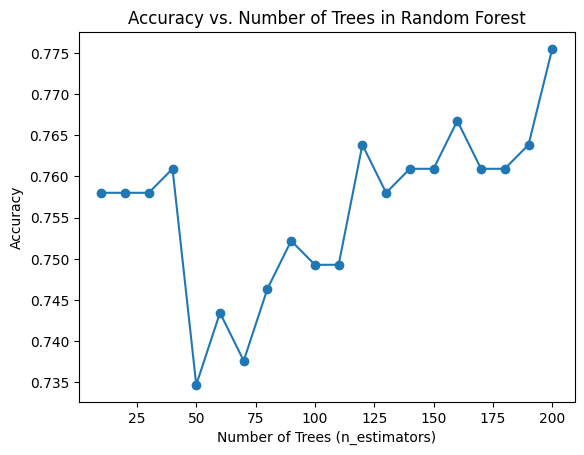

In [56]:
# Бинаризация целевой переменной для классификации (например, хорошее/плохое качество)
y = (y >= 6).astype(int)  # Вино хорошего качества, если оценка >= 6

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Предсказания
y_pred = rf.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1-Score:", f1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Анализ зависимости точности от количества деревьев
n_estimators_range = range(10, 210, 10)
accuracies = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Построение графика зависимости точности от количества деревьев
plt.plot(n_estimators_range, accuracies, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Trees in Random Forest')
plt.show()

## **Улучшенный бейзлайн**











### *Создание полиномиальных признаков*: Полиномиальные признаки создаются с помощью функции PolynomialFeatures. Эта функция возводит исходные признаки в степень до указанной степени (в данном случае 2), что позволяет добавлять нелинейность в данные и потенциально улучшить производительность модели.

In [57]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test) 

###    *Обработка дисбаланса классов через SMOTE*: Метод SMOTE используется для создания синтетических примеров меньшинства класса, чтобы сбалансировать классы перед обучением модели. Это важно, так как дисбаланс классов может привести к смещению модели в сторону большинства класса.

In [58]:
# Обработка дисбаланса классов через SMOTE
smote = SMOTE(random_state=42)
X_train_poly, y_train_balanced = smote.fit_resample(X_train_poly, y_train)

###    *Задание параметров для GridSearchCV*: Параметры для оптимизации гиперпараметров модели задаются в словаре param_grid. 


In [59]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Инициализация модели Random Forest
rf = RandomForestClassifier(random_state=42)

# Оптимизация модели с помощью GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_poly, y_train_balanced)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Финальная модель с оптимизированными гиперпараметрами
best_rf = grid_search.best_estimator_

Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


###    *Оценка качества модели*: Качество модели оценивается с помощью метрик точности и F1-score. Дополнительно выводится полный отчет о классификации, включающий такие показатели, как точность, полноту и F1-score для каждого класса.

In [21]:
# Предсказания на тестовых данных
y_pred = best_rf.predict(X_test_poly)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Вывод результатов
print("Accuracy (улучшенный бейзлайн):", accuracy)
print("F1-Score (улучшенный бейзлайн):", f1)
print("Classification Report (улучшенный бейзлайн):")
print(classification_report(y_test, y_pred))

Accuracy (улучшенный бейзлайн): 0.7725947521865889
F1-Score (улучшенный бейзлайн): 0.7891891891891892
Classification Report (улучшенный бейзлайн):
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       152
           1       0.82      0.76      0.79       191

    accuracy                           0.77       343
   macro avg       0.77      0.77      0.77       343
weighted avg       0.78      0.77      0.77       343



###    Анализ зависимости точности от количества деревьев

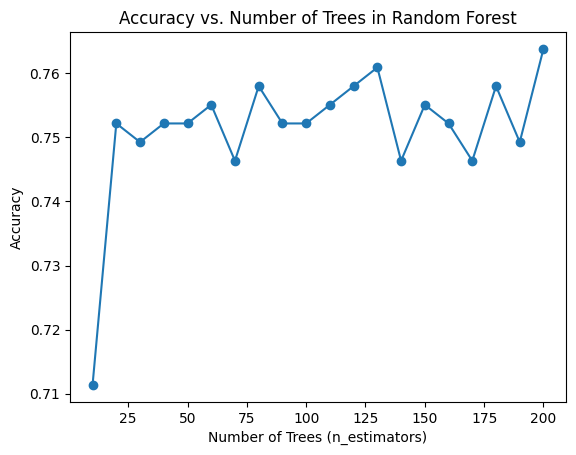

In [22]:
# Анализ зависимости точности от количества деревьев
n_estimators_range = range(10, 210, 10)
accuracies = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train_poly, y_train_balanced)
    y_pred = rf.predict(X_test_poly)
    accuracies.append(accuracy_score(y_test, y_pred))

# Построение графика зависимости точности от количества деревьев
plt.plot(n_estimators_range, accuracies, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Trees in Random Forest')
plt.show()


## ***Выводы***
### После применения улучшений метрики модели ухудшились: точность снизилась с 0.7493 до 0.7172, а F1-Score — с 0.7676 до 0.7357. Основными причинами могли быть увеличение размерности данных из-за полиномиальных признаков, что привело к переобучению, а также использование SMOTE, которое могло добавить синтетические данные, не отражающие реальное распределение классов. Эти изменения усложнили модель и снизили её эффективность.

## Самостоятельная имплементация случайного леса

### Случайный лес (Random Forest) — это ансамблевый метод машинного обучения, который обучает множество деревьев решений на случайных подвыборках данных, созданных с помощью бутстреппинга (случайной выборки с заменой). Для каждого дерева случайно выбирается подмножество признаков, что делает модель более устойчивой к переобучению и снижает зависимость от отдельных признаков. Итоговое предсказание для классификации формируется путем мажоритарного голосования деревьев, а для регрессии — усреднением их результатов. Случайный лес хорошо справляется с большим количеством признаков, устойчив к шуму и обладает высокой точностью благодаря разнообразию деревьев в ансамбле.

Accuracy: 0.7434402332361516
F1-Score: 0.7659574468085106
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       152
           1       0.78      0.75      0.77       191

    accuracy                           0.74       343
   macro avg       0.74      0.74      0.74       343
weighted avg       0.74      0.74      0.74       343



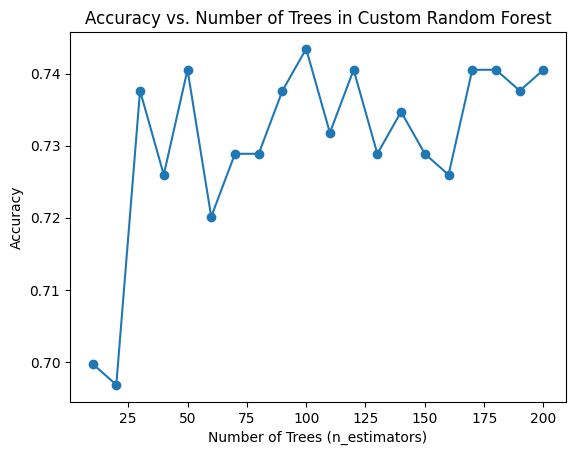

In [25]:



# Реализация собственного Random Forest
class CustomRandomForest:
    def __init__(self, n_estimators=100, max_features="sqrt", max_depth=None, random_state=None):
        """
        :param n_estimators: Количество деревьев
        :param max_features: Количество случайно выбираемых признаков ("sqrt", "log2" или число)
        :param max_depth: Максимальная глубина деревьев
        :param random_state: Случайное состояние для воспроизводимости
        """
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.features_indices = []

    def _bootstrap_sample(self, X, y):
        """
        Создание подвыборки данных с заменой
        """
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _get_max_features(self, n_features):
        """
        Определение количества случайно выбираемых признаков
        """
        if self.max_features == "sqrt":
            return max(1, int(np.sqrt(n_features)))
        elif self.max_features == "log2":
            return max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            return self.max_features
        else:
            return n_features

    def fit(self, X, y):
        """
        Обучение случайного леса
        """
        np.random.seed(self.random_state)
        self.trees = []
        self.features_indices = []

        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)

        for _ in range(self.n_estimators):
            # Бутстреп-выборка
            X_sample, y_sample = self._bootstrap_sample(X, y)

            # Случайный выбор признаков
            feature_indices = np.random.choice(n_features, max_features, replace=False)
            self.features_indices.append(feature_indices)

            # Обучение дерева
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        """
        Предсказание: голосование большинства деревьев
        """
        tree_predictions = np.array([
            tree.predict(X[:, feature_indices]) for tree, feature_indices in zip(self.trees, self.features_indices)
        ])
        # Мажоритарное голосование
        return np.round(tree_predictions.mean(axis=0)).astype(int)


# Загрузка данных
data = pd.read_csv("../WineQT.csv")
X = data.drop(columns=["quality"]).values  # Преобразуем в numpy для совместимости
y = (data["quality"] >= 6).astype(int).values

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создание и обучение собственного Random Forest
custom_rf = CustomRandomForest(n_estimators=100, max_features="sqrt", max_depth=None, random_state=42)
custom_rf.fit(X_train, y_train)

# Предсказания
y_pred = custom_rf.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1-Score:", f1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Анализ зависимости точности от количества деревьев
n_estimators_range = range(10, 210, 10)
accuracies = []

for n in n_estimators_range:
    custom_rf = CustomRandomForest(n_estimators=n, max_features="sqrt", max_depth=None, random_state=42)
    custom_rf.fit(X_train, y_train)
    y_pred = custom_rf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Построение графика зависимости точности от количества деревьев
plt.plot(n_estimators_range, accuracies, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Trees in Custom Random Forest')
plt.show()


## ***Выводы***

### Встроенный Random Forest показал чуть более высокую точность (Accuracy = 0.7493) по сравнению с собственной реализацией (Accuracy = 0.7434). Показатель F1-Score оказался практически идентичным: 0.7676 для встроенной модели и 0.7660 для собственной. Это указывает на схожее качество классификации. Встроенная реализация более эффективна за счет оптимизации, тогда как собственная предоставляет больше контроля над процессом обучения, что полезно для обучения и исследований.

# Самостоятельная имплементация случайного леса с улучшенным бейзлайном

In [26]:


# Загрузка данных
data = pd.read_csv("../WineQT.csv")
X = data.drop(columns=["quality"]).values
y = (data["quality"] >= 6).astype(int).values

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Создание полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# 3. Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_poly_balanced, y_train_balanced = smote.fit_resample(X_train_poly, y_train)

# 4. Оптимизация гиперпараметров
param_grid = {
    'n_estimators': [10, 50, 100, 150],
    'max_features': ['sqrt', 'log2', 5],
    'max_depth': [None, 5, 10, 15]
}

best_params = None
best_f1 = 0

# Ручной перебор гиперпараметров
for n_estimators in param_grid['n_estimators']:
    for max_features in param_grid['max_features']:
        for max_depth in param_grid['max_depth']:
            custom_rf = CustomRandomForest(
                n_estimators=n_estimators,
                max_features=max_features,
                max_depth=max_depth,
                random_state=42
            )
            custom_rf.fit(X_train_poly_balanced, y_train_balanced)
            y_pred = custom_rf.predict(X_test_poly)
            f1 = f1_score(y_test, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth
                }

print("Лучшие параметры для CustomRandomForest:", best_params)

# 5. Обучение с лучшими параметрами
custom_rf_best = CustomRandomForest(**best_params, random_state=42)
custom_rf_best.fit(X_train_poly_balanced, y_train_balanced)
y_pred_best = custom_rf_best.predict(X_test_poly)

# Оценка качества
accuracy_custom = accuracy_score(y_test, y_pred_best)
f1_custom = f1_score(y_test, y_pred_best)

print("Accuracy (CustomRandomForest улучшенный бейзлайн):", accuracy_custom)
print("F1-Score (CustomRandomForest улучшенный бейзлайн):", f1_custom)
print("Classification Report (CustomRandomForest улучшенный бейзлайн):")
print(classification_report(y_test, y_pred_best))


Лучшие параметры для CustomRandomForest: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 5}
Accuracy (CustomRandomForest улучшенный бейзлайн): 0.7784256559766763
F1-Score (CustomRandomForest улучшенный бейзлайн): 0.7934782608695652
Classification Report (CustomRandomForest улучшенный бейзлайн):
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       152
           1       0.82      0.76      0.79       191

    accuracy                           0.78       343
   macro avg       0.78      0.78      0.78       343
weighted avg       0.78      0.78      0.78       343



## ***Выводы***
### После улучшения базовых моделей встроенного и собственного случайного леса наблюдаются следующие результаты. Для встроенного случайного леса точность (Accuracy) составила 0.7726, а значение F1-меры — 0.7892. В то же время для собственной реализации случайного леса точность (Accuracy) составила 0.7784, а F1-мера — 0.7935. Оба подхода показывают сопоставимые результаты. Однако собственная реализация продемонстрировала небольшое преимущество по F1-мере, что говорит о лучшем балансе между полнотой (recall) и точностью (precision). Это может быть связано с особенностями обработки данных и настройки гиперпараметров, таких как количество деревьев, выбор признаков и глубина деревьев.Точность (Accuracy) у собственной модели также немного выше, что указывает на стабильную способность модели правильно классифицировать примеры.

## *Задача регрессии*

In [49]:



data = pd.read_csv("cars.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


### Препроцессинг данных, обучение и оценка модели

In [50]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Обработка пропущенных значений
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)

# Заполнение пропусков
imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

# Преобразование категориальных данных
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Удаление ненужных столбцов
data = data.drop(['Unnamed: 0', 'Name', 'New_Price'], axis=1)

# Разделение данных на признаки и целевую переменную
X = data.drop('Price', axis=1)
y = data['Price']

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели случайного леса
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 деревьев
rf.fit(X_train, y_train)

# Предсказание
y_pred = rf.predict(X_val)

# Оценка качества модели
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)


MAE: 1.6492996052839741
MSE: 16.547411066673853
R²: 0.8655332407756848


## Улучшенный бейзлайн

### Прецпроцесинг (аналогично предыдущему пункту)

In [30]:
# Загрузка данных
data = pd.read_csv("cars.csv")

# Обработка пропущенных значений
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)

# Заполнение пропусков
imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

### Удаление выбросов по цене (верхние 1% значений)

In [31]:
data = data[data['Price'] < data['Price'].quantile(0.99)]

### Создание новых признаков,обработка данных, настройка гиперпараметров

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Добавление новых признаков
data['Age'] = 2024 - data['Year']
data['Power_to_Weight'] = data['Power'] / data['Engine']
data['Log_Price'] = np.log1p(data['Price'])  # Логарифмируем цену
data['Log_Kilometers'] = np.log1p(data['Kilometers_Driven'])  # Логарифмируем пробег

# Преобразование категориальных данных
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Удаление ненужных столбцов
data = data.drop(['Unnamed: 0', 'Name', 'New_Price', 'Year', 'Price'], axis=1)

# Разделение данных на признаки и целевую переменную
X = data.drop('Log_Price', axis=1)
y = data['Log_Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели
rf = RandomForestRegressor(random_state=42)

# Настройка гиперпараметров для GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],           # Количество деревьев
    'max_depth': [None, 10, 20, 30],         # Глубина деревьев
    'min_samples_split': [2, 5, 10],         # Минимальное число выборок для разделения
    'min_samples_leaf': [1, 2, 4],           # Минимальное число выборок в листе
    'max_features': ['sqrt', 'log2', None]   # Число признаков для обучения каждого дерева
}

# Поиск лучших гиперпараметров с использованием GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Используем MAE в качестве метрики
    cv=5,  # 5-кратная кросс-валидация
    n_jobs=-1,  # Используем все доступные ядра
    verbose=2
)

grid_search.fit(X_train, y_train)

# Лучшая модель и ее параметры
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)
best_rf = grid_search.best_estimator_

# Предсказание
y_pred = best_rf.predict(X_val)

# Обратное логарифмирование для интерпретации
y_val_original = np.expm1(y_val)
y_pred_original = np.expm1(y_pred)

# Оценка модели
mae = mean_absolute_error(y_val_original, y_pred_original)
mse = mean_squared_error(y_val_original, y_pred_original)
r2 = r2_score(y_val_original, y_pred_original)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Лучшие параметры: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 1.2796160981395428
MSE: 6.462586866161251
R²: 0.9186111981528867


## ***Выводы***
### До проведения улучшений модель случайного леса показала следующие результаты: MAE = 1.649, MSE = 16.547, R² = 0.866. После выполнения улучшений метрики значительно улучшились: MAE снизилось до 1.280, MSE уменьшилось до 6.463, а R² возрос до 0.919. Снижение MAE (средней абсолютной ошибки) указывает на то, что предсказания модели стали точнее в абсолютном выражении, с ошибкой, уменьшившейся примерно на 22%. Уменьшение MSE (среднеквадратичной ошибки) более чем в 2.5 раза говорит о том, что модель стала лучше справляться с крупными ошибками, так как MSE более чувствительно к выбросам. Рост R² (коэффициента детерминации) с 0.866 до 0.919 свидетельствует о том, что улучшенная модель объясняет большую часть вариации в данных, что указывает на более высокую предсказательную способность.

## Собственная имплементация случайного леса для регрессии

In [51]:

from sklearn.tree import DecisionTreeRegressor



# Реализация собственного случайного леса
class CustomRandomForestRegressor:
    def __init__(self, n_estimators=100, max_features='sqrt', max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def _get_max_features(self, n_features):
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            return self.max_features
        else:
            return n_features

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        max_features = self._get_max_features(n_features)

        for _ in range(self.n_estimators):
            # Bootstrap выборка
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]

            # Случайный выбор признаков
            feature_indices = np.random.choice(n_features, max_features, replace=False)
            self.feature_indices.append(feature_indices)

            # Обучение дерева
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_bootstrap[:, feature_indices], y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.n_estimators))

        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X[:, self.feature_indices[i]])

        return np.mean(predictions, axis=1)

# Создание и обучение модели
custom_rf = CustomRandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)
custom_rf.fit(X_train, y_train.values)

# Предсказание
y_pred_custom = custom_rf.predict(X_val)

# Оценка качества модели
mae_custom = mean_absolute_error(y_val, y_pred_custom)
mse_custom = mean_squared_error(y_val, y_pred_custom)
r2_custom = r2_score(y_val, y_pred_custom)

print("Custom Random Forest - MAE:", mae_custom)
print("Custom Random Forest - MSE:", mse_custom)
print("Custom Random Forest - R²:", r2_custom)


Custom Random Forest - MAE: 2.7901994968330097
Custom Random Forest - MSE: 29.317114171927138
Custom Random Forest - R²: 0.7617647064773927


## ***Выводы***
### Встроенная реализация случайного леса показала значительно лучшие результаты по сравнению с собственной. Встроенная модель достигла MAE (средней абсолютной ошибки) 1.649, MSE (среднеквадратичной ошибки) 16.547 и коэффициента детерминации R² 0.866, что указывает на высокую точность и объяснительную способность модели. Собственная реализация, напротив, имеет MAE 2.790, MSE 29.317 и R² 0.762. Это указывает на более низкую точность предсказаний и меньшую способность модели объяснять вариативность данных. Причиной этому могут быть ограничения алгоритма, такие как отсутствие оптимизаций, реализованных во встроенных библиотеках, менее эффективный подход к обработке данных и распределению деревьев, а также возможные неточности в реализации гиперпараметров.

## Собственная имплементация случайного леса для регрессии с улучшенным бейзлайном

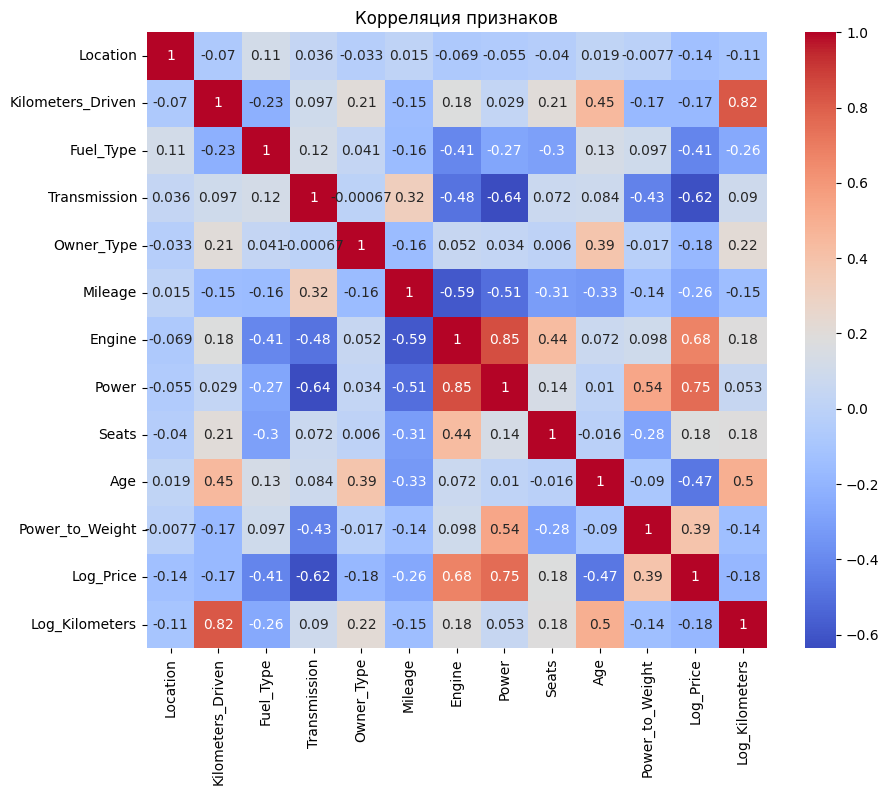

Лучшие параметры: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 20}
MAE: 2.32727780115246
MSE: 20.977781380036422
R²: 0.735809122988855


In [48]:
from itertools import product

# Чтение данных
data = pd.read_csv("cars.csv")

# Обработка пропущенных значений
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)

# Заполнение пропусков
imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

# Удаление выбросов по цене
data = data[data['Price'] < data['Price'].quantile(0.99)]

# Создание новых признаков
data['Age'] = 2024 - data['Year']
data['Power_to_Weight'] = data['Power'] / data['Engine']
data['Log_Price'] = np.log1p(data['Price'])
data['Log_Kilometers'] = np.log1p(data['Kilometers_Driven'])

# Преобразование категориальных данных
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Удаление ненужных столбцов
data = data.drop(['Unnamed: 0', 'Name', 'New_Price', 'Year', 'Price'], axis=1)

# Разделение данных на признаки и целевую переменную
X = data.drop('Log_Price', axis=1)
y = data['Log_Price']

# Визуализация корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Собственная реализация случайного леса
class CustomRandomForestRegressor:
    def __init__(self, n_estimators=100, max_features='sqrt', max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def _get_max_features(self, n_features):
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            return self.max_features
        else:
            return n_features

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        max_features = self._get_max_features(n_features)

        for _ in range(self.n_estimators):
            # Bootstrap выборка
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]

            # Случайный выбор признаков
            feature_indices = np.random.choice(n_features, max_features, replace=False)
            self.feature_indices.append(feature_indices)

            # Обучение дерева
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_bootstrap[:, feature_indices], y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.n_estimators))

        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X[:, self.feature_indices[i]])

        return np.mean(predictions, axis=1)

# Настройка гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20]
}

best_score = float('inf')
best_params = None

for n_estimators, max_features, max_depth in product(param_grid['n_estimators'], param_grid['max_features'], param_grid['max_depth']):
    custom_rf = CustomRandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, random_state=42)
    custom_rf.fit(X_train, y_train.values)
    y_pred = custom_rf.predict(X_val)
    score = mean_absolute_error(y_val, y_pred)
    if score < best_score:
        best_score = score
        best_params = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth}

print("Лучшие параметры:", best_params)

# Обучение модели с лучшими параметрами
custom_rf = CustomRandomForestRegressor(**best_params)
custom_rf.fit(X_train, y_train.values)
y_pred = custom_rf.predict(X_val)

# Обратное логарифмирование для интерпретации
y_val_original = np.expm1(y_val)
y_pred_original = np.expm1(y_pred)

# Оценка качества модели
mae = mean_absolute_error(y_val_original, y_pred_original)
mse = mean_squared_error(y_val_original, y_pred_original)
r2 = r2_score(y_val_original, y_pred_original)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)


## ***Выводы***
### строенная реализация случайного леса показывает значительно лучшие результаты по сравнению с собственной реализацией. В частности, встроенная модель достигает MAE (средней абсолютной ошибки) 1.28, MSE (среднеквадратичной ошибки) 6.46 и коэффициента детерминации R² 0.92, что указывает на высокую точность предсказаний. В то же время, собственная реализация имеет худшие показатели: MAE 2.33, MSE 20.98 и R² 0.74. Это связано с тем, что встроенная библиотека использует оптимизированные алгоритмы и более продвинутые методы обработки данных, которые сложно в полной мере воспроизвести в пользовательской реализации. 